# Medical Data Notebook

In [1]:
# Importamos los módulos necesarios
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [2]:
# Leemos los datos del archivo medical_data.csv y creamos nuestro dataframe
df = pd.read_csv('medical_examination.csv',sep=',')

In [3]:
#Revisamos la forma de nuestro dataframe, tipos de dato y descartamos que haya datos faltantes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


In [3]:
# 1. Agregamos una columna que indique si la persona tiene sobrepeso o no (0: No tiene Sobrepeso,1: Tiene Sobrepeso) 
# basado en su Indice de Masa Corporal ( peso(kg)/altura(m)^2 )

#Transformamos la altura de cm a metros
#Generamos una serie en donde si IBM es mayor a 25 tiene sobre peso es True y si no, es False
#Multiplicamos por 1 para que el valor sea numérico
df['overweight'] = (df.weight/((df.height/100)**2)>25)*1

df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,overweight
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1,0
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0,0


In [4]:
#2. Normalizamos los valores de colesterol y glucosa de la siguiente manera:
#Si el valor es 1, hacemos el valor 0.
#Si el valor es mayor a 1 entonces, hacemos el valor 1.

#Generamos las series en donde si cho o glu son mayor a 1 devuelva True, de lo contrario False.
#Multiplicamos por 1 para que el valor sea numérico
df['cholesterol'] = (df.cholesterol >1)*1
df['gluc'] = (df.gluc >1)*1

df[['cholesterol','gluc']].value_counts()

cholesterol  gluc
0            0       48672
1            0       10807
             1        6808
0            1        3713
dtype: int64

In [5]:
# 3.1 Como queremos representar los valores medicos para personas con alguna condición cardivascular (1) o no (0),
# debemos covertir los datos en un formato largo, utilizando la funcion melt de la siguiente manera:

#Agregamos la columna id_vars=['cardio'] con sus valores del dataframe
# Convertimos las columnas value_vars=['active','alco','cholesterol','gluc','overweight','smoke'] en una variable,
# la llamamos variable var_name=['variable']
# y a su valor en el Dataframe la llamamos value_name ='value'

df_cat = pd.melt(df,id_vars=['cardio'],value_vars=['active','alco','cholesterol','gluc','overweight','smoke'], 
            var_name=['variable'],value_name ='value')

#Agrupamos los datos de manera que se dividan por la variable cardio, y además que muestre la cuenta asignandole el nombre 'total'
df_cat = df_cat.groupby(['cardio', 'variable', 'value'], as_index = False).size().rename(columns={'size':'total'})
df_cat

,cardio,variable,value,total
0,0,active,0,6378
1,0,active,1,28643
2,0,alco,0,33080
3,0,alco,1,1941
4,0,cholesterol,0,29330
5,0,cholesterol,1,5691
6,0,gluc,0,30894
7,0,gluc,1,4127
8,0,overweight,0,15915
9,0,overweight,1,19106


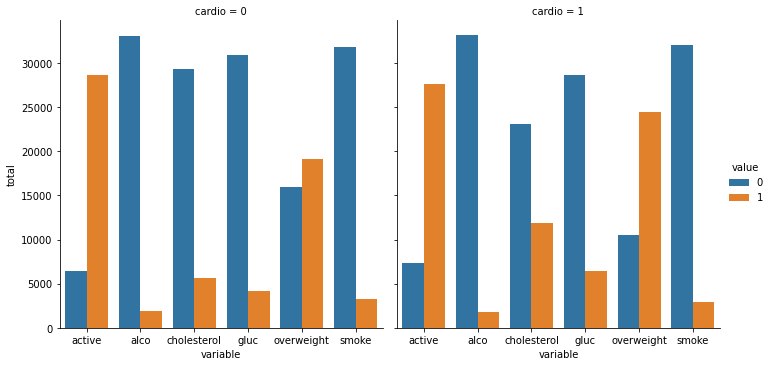

In [7]:
# 3.2 Generamos nuestro gráfico usando catplot de Seaborn de tipo Count (kind='count')
#Elaborando un gráfico para cada valor de cardio (col='cardio)'
#Y agrupando las cuentas por el valor de cada variable (hue='value')

sns.catplot(
    x = 'variable',
    y = 'total',
    kind = 'bar',
    hue = 'value',
    col = 'cardio',
    data = df_cat
    )

In [8]:
# 4.1 Debemos limpiar nuevamente los datos para poder realizar nuestro Heat Map.
# Eliminamos los registros en que los que la presión diastólica es mayor que la sistólica.
# Eliminamos los registros de altura y peso menores al percentil 2.5 y mayores al percentil 97,5
df_heat= df[(df['ap_lo'] <= df['ap_hi']) & 
   (df['height'] >= df['height'].quantile(0.025)) & 
   (df['height'] <= df['height'].quantile(0.975)) & 
   (df['weight'] >= df['weight'].quantile(0.025)) &
   (df['weight'] <= df['weight'].quantile(0.975))]

#Para realizar el Heat map, debemos generar nuestra tabla de correlación. Además la redondeamos a un solo decimal.
corr = df_heat.corr().round(1)
corr

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,overweight
id,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,0.0,0.0,-0.0
age,0.0,1.0,-0.0,-0.1,0.1,0.0,0.2,0.1,0.1,-0.0,-0.0,-0.0,0.2,0.1
gender,0.0,-0.0,1.0,0.5,0.1,0.0,0.1,-0.0,-0.0,0.3,0.2,0.0,0.0,-0.1
height,0.0,-0.1,0.5,1.0,0.3,0.0,0.0,-0.1,-0.0,0.2,0.1,-0.0,-0.0,-0.1
weight,0.0,0.1,0.1,0.3,1.0,0.0,0.2,0.1,0.1,0.1,0.1,-0.0,0.2,0.7
ap_hi,0.0,0.0,0.0,0.0,0.0,1.0,0.1,0.0,0.0,-0.0,0.0,-0.0,0.1,0.0
ap_lo,0.0,0.2,0.1,0.0,0.2,0.1,1.0,0.2,0.1,0.0,0.0,0.0,0.3,0.2
cholesterol,0.0,0.1,-0.0,-0.1,0.1,0.0,0.2,1.0,0.4,0.0,0.0,0.0,0.2,0.1
gluc,0.0,0.1,-0.0,-0.0,0.1,0.0,0.1,0.4,1.0,-0.0,0.0,-0.0,0.1,0.1
smoke,-0.0,-0.0,0.3,0.2,0.1,-0.0,0.0,0.0,-0.0,1.0,0.3,0.0,-0.0,-0.0


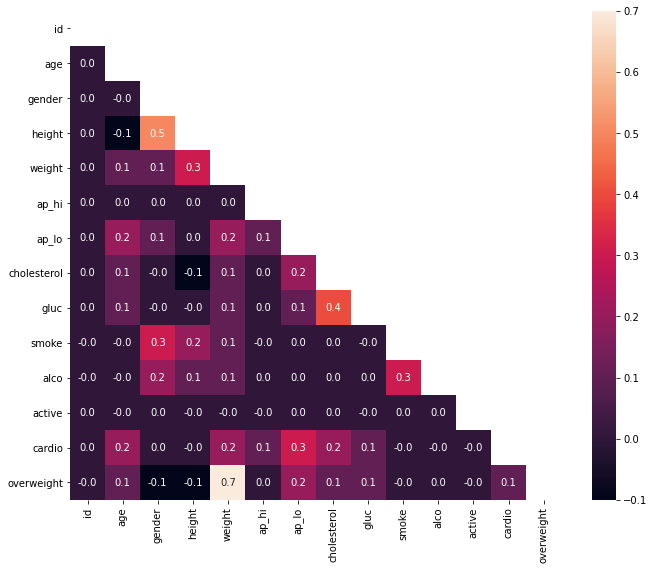

In [9]:
# 4.1 Antesde graficar el Heat Map debemos generar una variable para enmascarar el triángulo superior usando triu() de numpy.
mask = np.triu(np.ones_like(corr, dtype=bool))

#Generamos el Heat Map. Mostrando los valores de correlación(annot=True) y formateandolos con un punto flotante. (fmt = '.1f')
f, ax = plt.subplots(figsize=(11, 9))
ax = sns.heatmap(corr, mask=mask, annot=True, fmt='.1f')